### Republic Of Ireland Milk Sales

Milk Sales (Dairy) for Human Consumption (Million Litres) by Month and Type of Milk
- Data retrived from https://data.gov.ie/dataset/milk-sales-dairy-for-human-consumption-million-litres-by-month-and-type-of-milk
- Landing page http://www.cso.ie/px/pxeirestat/Statire/SelectVarVal/Define.asp?maintable=AKM02&PLanguage=0

In [1]:
#Imports and Setup
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import seaborn as sns
from IPython.display import HTML, display
import matplotlib.patches as mpatches
import matplotlib.dates as dates
from statsmodels.formula.api import ols
import statsmodels.api as sm

%matplotlib inline

In [2]:
#Read cvs file into a data frame
dfmilk= pd.read_csv("./data/AKM02.csv")

In [3]:
dfmilk.tail()

,Unnamed: 0,Type.of.Milk,Month,value
2255,2256,All Milk,2017M08,45.2
2256,2257,Whole Milk,2017M08,27.4
2257,2258,Skimmed and Semi-skimmed milk,2017M08,17.8
2258,2259,Skimmed Milk,2017M08,1.7
2259,2260,Semi-skimmed milk,2017M08,16.1


In [4]:
# Remove the index column created in the export to csv from R
del dfmilk['Unnamed: 0']
# Rename columns
dfmilk.rename(columns={'Type.of.Milk': 'Type', 'Month': 'Date' }, inplace=True)
# Remove M character from Data column
dfmilk['Date']  = dfmilk['Date'].str.replace('M','')

In [5]:
# Change column to date data type
dfmilk['Date'] = pd.to_datetime(dfmilk['Date'], format='%Y%m')
# Set date column as the data frame index
dfmilk.index = dfmilk.Date

In [6]:
dfmilk.head(2)

,Type,Date,value
Date,,,
1980-01-01,All Milk,1980-01-01,38.2
1980-01-01,Whole Milk,1980-01-01,38.2


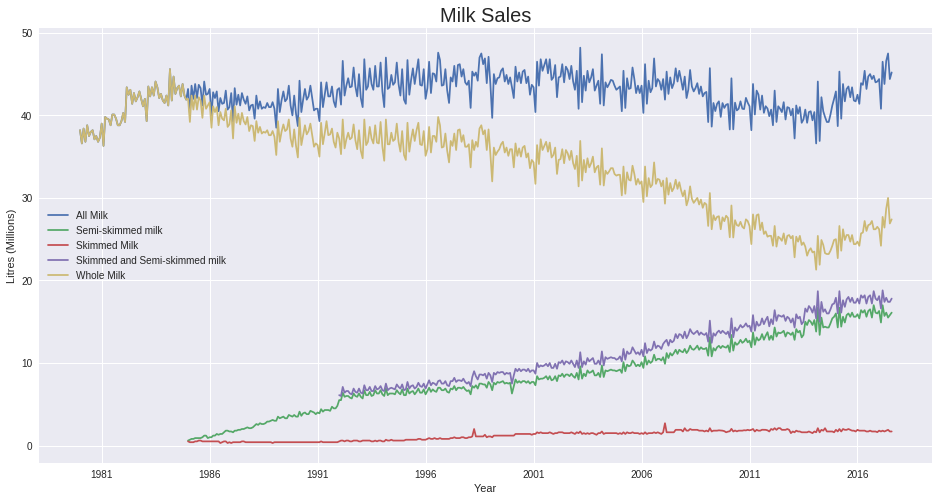

In [7]:
# Plot a graph with a line for each milk type
plt.figure(figsize=(16, 8))
for key, grp in dfmilk.groupby('Type'):
    plt.plot(grp['value'], label=key)
plt.title("Milk Sales", fontsize = 20) 
plt.xlabel("Year")    
plt.ylabel("Litres (Millions)")    
plt.legend(loc='best')     
plt.show()

- For the most part as Skimmed and Semi Skimmed milk sales have increased, Whole milk sales have decreased.
- We can test the significane of this relationship.

In [8]:
# Create a pivot table to work with
milkpvt = dfmilk.pivot(index="Date", columns="Type", values="value")

# Reduce column names to one word for ease of use
milkpvt.rename(columns={"All Milk": 'All',
                        "Semi-skimmed milk": 'Semi',
                        "Skimmed Milk": 'Skimmed',
                        "Skimmed and Semi-skimmed milk": 'SkimmedandSemi',
                        "Whole Milk": 'Whole'                        
                       }, inplace=True)

The "Skimmed and Semi-skimmed milk" column is null before 1992 but we can populate some values for the column by summing the "Skimmed Milk" and "Semi-skimmed milk" columns.

In [9]:
# Update SkimmedandSemi column where it is null
milkpvt.loc[milkpvt['SkimmedandSemi'].isnull(), 'SkimmedandSemi'] = milkpvt['Skimmed'] + milkpvt['Semi']

We can see some stats about the millions of litres of milk sold since 1980 for each different type 

In [10]:
milkpvt.describe()

Type,All,Semi,Skimmed,SkimmedandSemi,Whole
count,452.000000,392.000000,392.000000,392.000000,452.000000
mean,42.680088,8.508801,1.195306,9.702730,34.269535
std,2.275717,4.268561,0.574715,4.786815,5.606546
min,36.300000,0.600000,0.300000,1.100000,21.300000
25%,41.100000,6.100000,0.600000,6.675000,29.975000
50%,42.900000,8.000000,1.400000,9.400000,35.900000
75%,44.100000,11.870000,1.700000,13.700000,38.300000
max,48.200000,17.000000,2.700000,18.800000,45.600000


In [11]:
# Remove other columns besides "Whole milk" and "Skimmed and semiskimmed" to compare these only
del milkpvt['All']
del milkpvt['Semi']
del milkpvt['Skimmed']

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


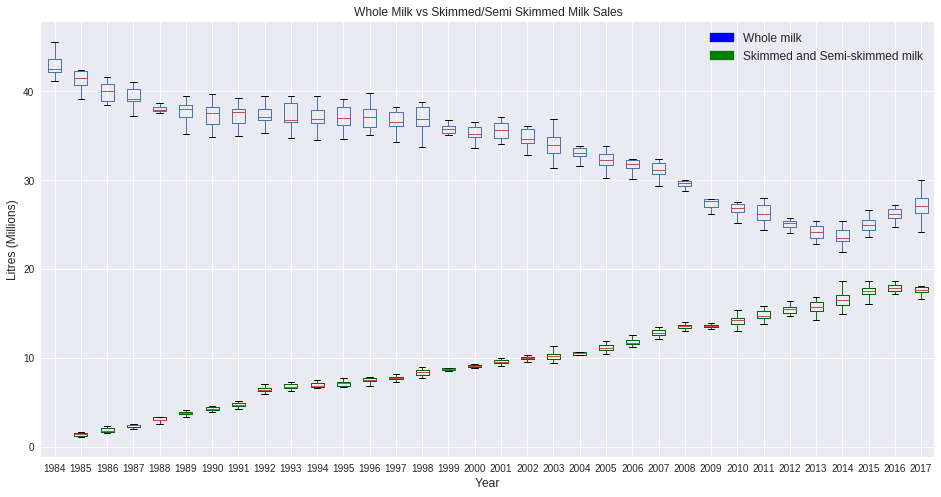

In [12]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Whole Milk vs Skimmed/Semi Skimmed Milk Sales')
ax.set_xlabel('Year', fontsize='large'), ax.set_ylabel('Litres (Millions)', fontsize='large')
blue_patch = mpatches.Patch(color='blue', label='Whole milk')
green_patch = mpatches.Patch(color='green', label='Skimmed and Semi-skimmed milk')
plt.legend(handles=[blue_patch,green_patch],  fontsize='large')

#Plot only values after 84 to save plot space
milkpvt84 = milkpvt['1984':]

milkpvt84.set_index([milkpvt84.index,milkpvt84.index.year]).Whole.unstack().plot.box(ax = ax)
greencolor = dict(boxes='DarkGreen',whiskers='Green')
milkpvt84.set_index([milkpvt84.index,milkpvt84.index.year]).SkimmedandSemi.unstack().plot.box(ax = ax, color=greencolor)

We can see that until recent years Whole milk has more variation within a year as the boxplots are larger compared to the tight boxes of Skimmed and Semi-skimmed. It could be that whole milk was more affected by seasonal changes.

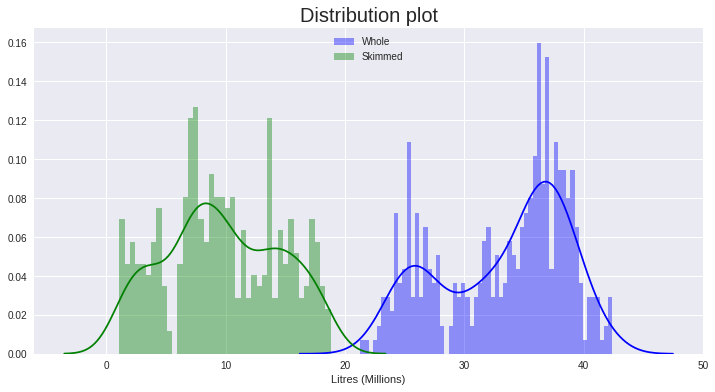

In [13]:
sns.set(rc={"figure.figsize": (12, 6)})
sns.distplot(milkpvt['1985':].Whole,bins=60,color='blue', label='Whole');
sns.distplot(milkpvt['1985':].SkimmedandSemi,bins=40,color='green', label='Skimmed');
plt.title('Distribution plot' , fontsize = 20)
plt.xlabel("Litres (Millions)")
plt.legend(loc=9);

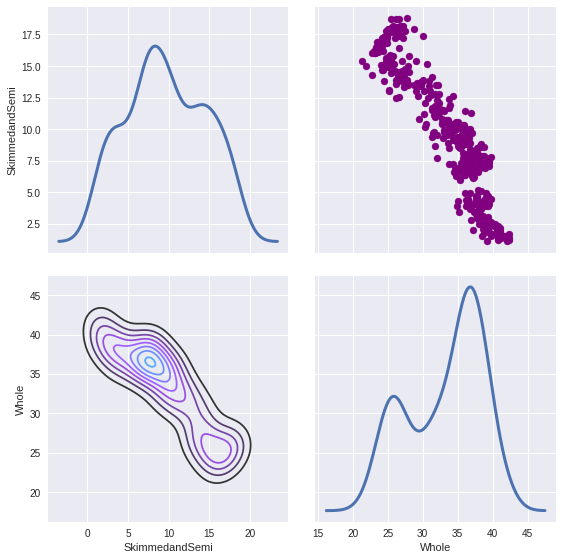

In [14]:
#We can get more contron on the plots by using pair grid
returns_fig=sns.PairGrid(milkpvt['1985':], size=4)
#Map_upper us used to plot graphs in upper grid
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(sns.kdeplot, lw=3, legend=False)

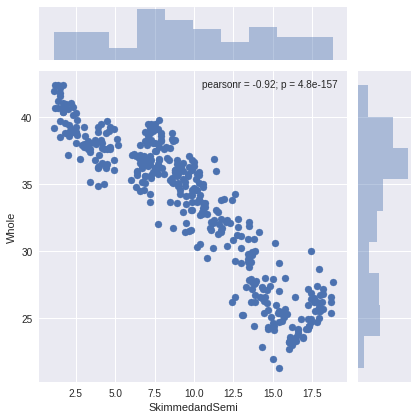

In [15]:
sns.jointplot(milkpvt.SkimmedandSemi,milkpvt.Whole)

The pearsonr value of -0.92 shows an inverse relationalship between sales of Whole milk and Skimmed/Semiskimmed milk.

##  Ordinary Least Squares Analysis

In [16]:
milk_model = ols("Whole ~ SkimmedandSemi", data=milkpvt).fit()

In [17]:
milk_model_summary = milk_model.summary()
HTML(
milk_model_summary\
.as_html()
)

The Ordinary Least Squares coefficient of -1 for Skimmed and Semi-skimmed milk against Whole milk indicate that for each extra litre of whole purchased there is an equivlent decrease of one Skimmed and Semi-skimmed milk purchases which could be explained by people making a choice between the two.

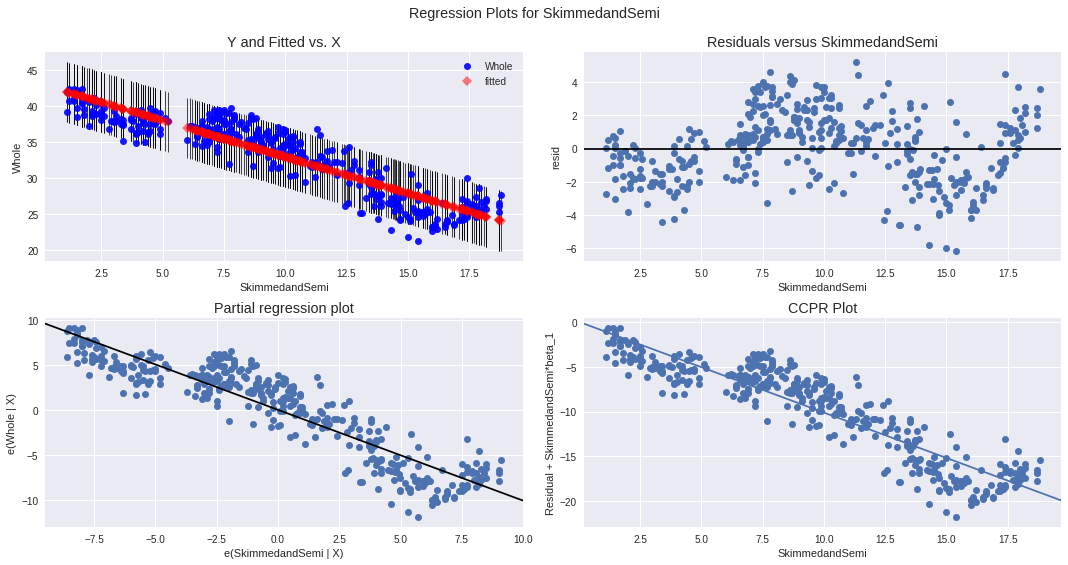

In [18]:
# use figsize to adjust size, and pass in to plot_regress_exog
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(milk_model, "SkimmedandSemi", fig=fig)

## Predict future milk sales with Prophet

In [19]:
#change column names as required by Prophet
dfmilk.rename(columns={ 'value': 'y','Date': 'ds' }, inplace=True)

# Make a dataframe of just the All Milk values
almilk = dfmilk[dfmilk['Type'] == 'All Milk']

# Remove the type column as as just "All Milk" is left
del almilk['Type']

In [20]:
model = Prophet()
model.fit(almilk)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = model.make_future_dataframe(periods=72, freq='MS')

In [22]:
forecast = model.predict(future)

## Plot of All Milk Sales with 72 months future prediction

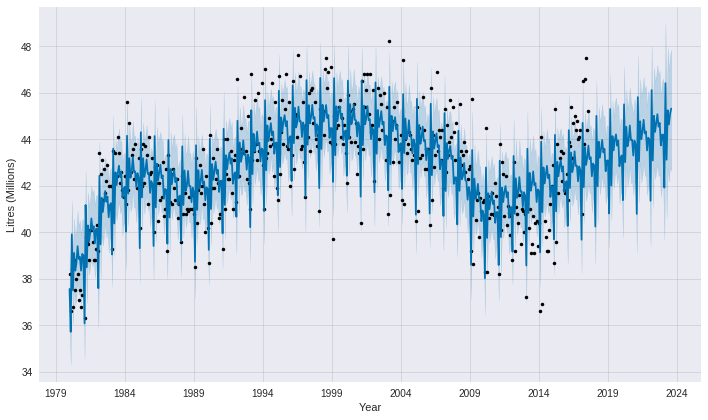

In [23]:
ax = model.plot(forecast, xlabel="Year",ylabel="Litres (Millions)")

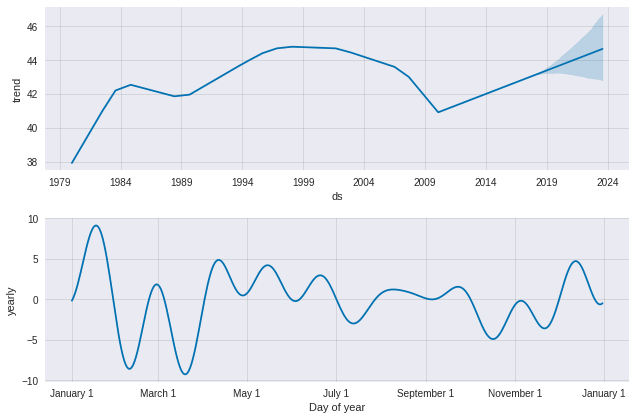

In [24]:
ax = model.plot_components(forecast)

The trend shows a peak for all milk sales in 1999 followed by a decreased until 2010 and a consistent increase since.

In the yearly component we see the month that usually has the higest sales is at the start of the year followed by 2 months with the lowest sales.